# Home Assignment 2
###### Bayesian inference from COVID-19 pandemic data using Markov chain Monte Carlo

In [493]:
import numpy as np
import pandas as pd

Dataprocessing

In [494]:
df_germany_I = pd.read_csv('germany_infected.csv')
df_germany_R = pd.read_csv('germany_removed.csv')
df_iran_I = pd.read_csv('iran_infected.csv')
df_iran_R = pd.read_csv('iran_removed.csv')

frame = [df_germany_I,df_germany_R]
df_germany = pd.concat(frame,axis=1)
df_germany.columns = ['I', 'R']


frame = [df_iran_I,df_iran_R]
df_iran = pd.concat(frame,axis=1)
df_iran.columns = ['I', 'R']

In [495]:
P_germany = 83000000 #Population size germany
P_iran = 84000000 #Population size iran

df_germany = pd.concat([P_germany-df_germany['I']-df_germany['R'],df_germany['I'],df_germany['R']],axis=1) #Adding Supseptical to the dataframe
df_germany.columns = ['S','I', 'R']

df_iran = pd.concat([P_iran-df_iran['I']-df_iran['R'],df_iran['I'],df_iran['R']],axis=1) #Adding Supseptical to the dataframe
df_iran.columns = ['S','I', 'R']

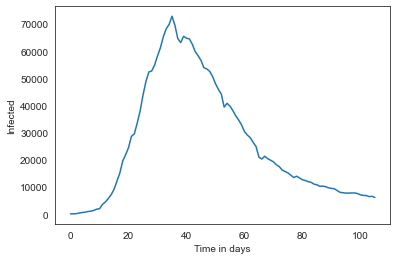

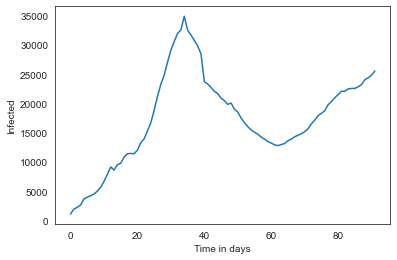

In [569]:
import matplotlib.pyplot as plt

plt.plot(df_germany['I'])
plt.xlabel('Time in days')
plt.ylabel('Infected')
plt.savefig('Germany_I.png',dpi=100)
plt.show()

plt.plot(df_iran['I'])
plt.xlabel('Time in days')
plt.ylabel('Infected')
plt.savefig('Iran_I.png',dpi=100)
plt.show()

Functions

In [496]:
from scipy.stats import binom , nbinom , gamma , beta , norm , randint , uniform
from scipy.special import gamma, factorial, loggamma


def pi_lambda(y,Lambda):
    f=0
 
    phi = 0.995
   
    start_indx = y.index.start
    stop_indx = y.index.stop
    for k in range(start_indx,stop_indx-1,1):
        I_t=y.loc[k,'I']
        I_t1=y.loc[k+1,'I']
        S_t=y.loc[k,'S']
        S_t1=y.loc[k+1,'S']
        
        p_si = 1-np.exp(-Lambda*I_t/P)
        kappa = (1/phi-1)*S_t*p_si
       
        f += loggamma(S_t-S_t1+kappa)-loggamma(kappa)+kappa*np.log(1-phi)
    
    f += (alpha_i-1)*np.log(Lambda)-beta_i*Lambda
    return f

def pi_t(y,Lambda):
    f=0
    phi = 0.995
    start_indx = y.index.start
    stop_indx = y.index.stop
    for k in range(start_indx,stop_indx-1,1):
        I_t=y.loc[k,'I']
        I_t1=y.loc[k+1,'I']
        S_t=y.loc[k,'S']
        S_t1=y.loc[k+1,'S']
        
        p_si = 1-np.exp(-Lambda*I_t/P)    
        kappa = (1/phi-1)*S_t*p_si
       
        f += loggamma(S_t-S_t1+kappa)-loggamma(S_t-S_t1+1)-loggamma(kappa)+kappa*np.log(1-phi)+(S_t-S_t1)*np.log(phi) 
  
    return f
        
def RW_Lambda(Lambda):
    epsilon=norm.rvs(loc=0, scale=1, size=1, random_state=None)
    return Lambda + sigma*epsilon[0]

def RW_t(t):
    epsilon=[-2,-1,1,2]   #M=2
    indx = randint.rvs(0,len(epsilon)) 
    return t+epsilon[indx]

Hybrid sampler

In [553]:
M = 15000 #Number of iteration

y=df_germany #Choosing data to work with
P=P_germany

T=len(y)-1

#Hyperparameters
a=20
b=30
alpha_i=2
beta_i=5
sigma=0.01

d=4 #Number of breakpoints = d-1

#Initilizing theta
t=np.zeros([d+1,M])
t[0,:]=0
t[d,:]=T
t[1,0]=20
t[2,0]=40
t[3,0]=60

Lambda=np.zeros([d,M])
Lambda[:,0]=1
p_ir=np.zeros([1,M])

#Counter 
sucess=0
fail=0


for j in range(1,M,1):
    p_ir[0,j] = beta.rvs(a+y.loc[0,'I']-y.loc[T,'I']+y.loc[0,'S']-y.loc[T,'S'],b+y.loc[T,'S']-y.loc[0,'S']+np.sum(y.loc[1:T,'I'])) #Gibbs step
    
    for i in range(d):  #Metropolis-Hasting step for each lambda_i
        Lambda_cand = RW_Lambda(Lambda[i,j-1]) #Random walk
      
        if Lambda_cand < 0:
            alpha=0
        else:
            #Dividing the data for each breakpoint
            h_0 = t[i,j-1].astype(int)
            h_1 = t[i+1,j-1].astype(int)
            
            alpha=min(1,np.exp(pi_lambda(y[h_0:h_1],Lambda_cand)-pi_lambda(y[h_0:h_1],Lambda[i,j-1])))

        U = uniform.rvs()  
        if U <= alpha:   #Updating with probability alpha
            Lambda[i,j] = Lambda_cand
            if i==1:
                sucess += 1  
        else:
            Lambda[i,j] = Lambda[i,j-1]
            if i==1:
                fail +=1
    
    for i in range(d-1):   
        t_cand = RW_t(t[i+1,j-1])   #Random walk
    
        if t_cand <= t[i,j-1] or t_cand >= t[i+2,j-1]: 
            alpha = 0
        else:
            #Dividing the data for each breakpoint
            h_0 = t[i,j-1].astype(int)
            h_1 = t[i+1,j-1].astype(int)
            h_2 = t[i+2,j-1].astype(int)
        
            iter1 = pi_t(y[h_0:h_1],Lambda[i,j])  #Take the data to the left of the breakpoint
            iter1 = iter1 + pi_t(y[h_1:h_2],Lambda[i+1,j]) #Adds the data to the right
            
            iter2 = pi_t(y[h_0:int(t_cand)],Lambda[i,j]) #The same for the candidate
            iter2 = iter2 + pi_t(y[int(t_cand):h_2],Lambda[i+1,j])
       
            alpha =min(1,np.exp(iter2-iter1))     
                  
        U = uniform.rvs()  
        if U <= alpha:   #Updating with probability alpha
            t[i+1,j] = t_cand
        else:
            t[i+1,j] = t[i+1,j-1]
            
    
#print('Lambda:',Lambda)
print('Sucess:',sucess)
print('Fail:',fail)
print('%:',sucess/(sucess+fail))
    

Sucess: 7287
Fail: 7712
%: 0.4858323888259217


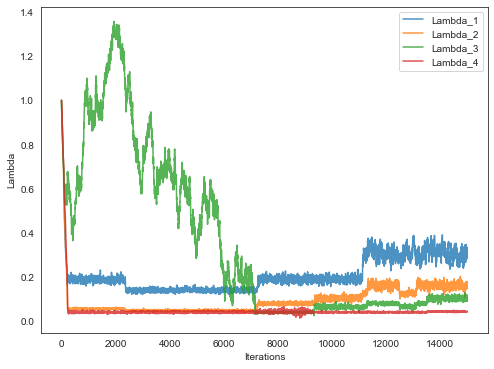

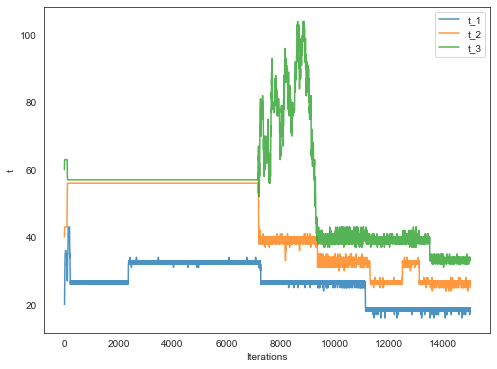

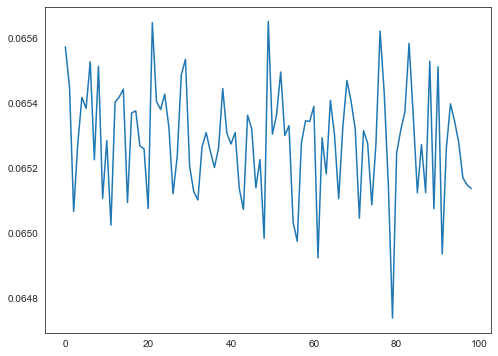

[[0.         0.06557382 0.06544932 ... 0.06538804 0.06528348 0.06522664]]


In [555]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(Lambda[0,:],alpha=0.8,label='Lambda_1')
plt.plot(Lambda[1,:],alpha=0.8,label='Lambda_2')
plt.plot(Lambda[2,:],alpha=0.8,label='Lambda_3')
plt.plot(Lambda[3,:],alpha=0.8,label='Lambda_4')
plt.xlabel('Iterations')
plt.ylabel('Lambda')
plt.legend(loc='upper right')
plt.savefig('Breakpoints3_Lambda.png',dpi=100)
#plt.savefig('beta6.png',dpi=100)
plt.show()


plt.figure(figsize=(8,6))
plt.plot(t[1,:],alpha=0.8,label='t_1')
plt.plot(t[2,:],alpha=0.8,label='t_2')
plt.plot(t[3,:],alpha=0.8,label='t_3')
plt.xlabel('Iterations')
plt.ylabel('t')
plt.legend(loc='upper right')
plt.savefig('Breakpoints3_t.png',dpi=100)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(p_ir[0,1:100])
plt.show()
print(p_ir)

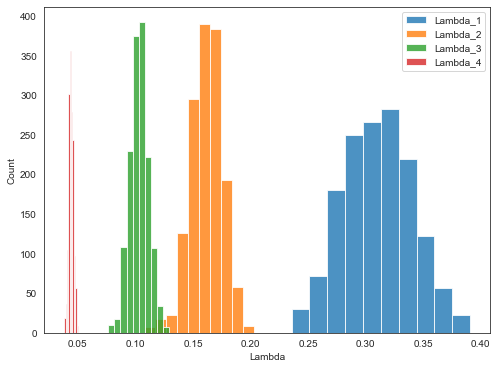

In [562]:
# Set a burn in according to the plots above
burn_in=13500 

x1 = Lambda[0,burn_in:]
x2 = Lambda[1,burn_in:]
x3 = Lambda[2,burn_in:]
x4 = Lambda[3,burn_in:]

# Plot
plt.figure(figsize=(8,6))
plt.hist(x1,bins=10,alpha=0.8,label='Lambda_1')
plt.hist(x2,bins=10,alpha=0.8,label='Lambda_2')
plt.hist(x3,bins=10,alpha=0.8,label='Lambda_3')
plt.hist(x4,bins=10,alpha=0.8,label='Lambda_4')
plt.xlabel('Lambda')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.savefig('Breakpoints3_Lambda_hist.png',dpi=100)
plt.show()

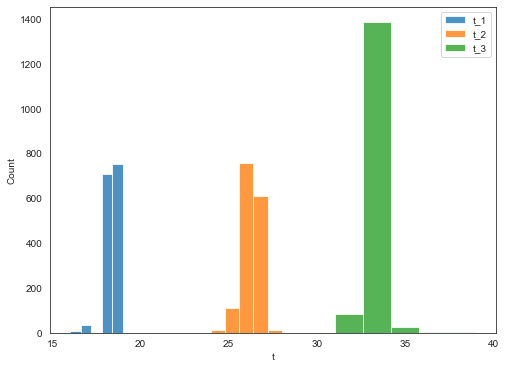

In [564]:
x1 = t[1,burn_in:]
x2 = t[2,burn_in:]
x3 = t[3,burn_in:]

# Plot
plt.figure(figsize=(8,6))
plt.hist(x1,bins=5,alpha=0.8,label='t_1')
plt.hist(x2,bins=5,alpha=0.8,label='t_2')
plt.hist(x3,bins=5,alpha=0.8,label='t_3')

plt.xlabel('t')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.savefig('Breakpoints3_t_hist.png',dpi=100)
plt.show()